In [1]:
import sys
sys.path.insert(1,'/home/spencer/research/OpenRadar') # needed to import openradar not in folder
try: sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages') # fixes issues with env variables
except: pass

In [2]:
import numpy as np
import mmwave as mm
import matplotlib.pyplot as plt
import pickle
import os
import copy

## Getting the Data

In [3]:
radar_frames_path = 'radar_frames.txt'
cfg_path = '/home/spencer/research/ti-radar-hardware/mmWave/scripts/configs/14xx/indoor_human_rcs.cfg' #radar config
rgb_dir_path = '/home/spencer/research/radar-rgb-bfs/RGB_images'

radar_frames = pickle.load(open(radar_frames_path,'rb'))
iwr_cfg_cmd = mm.dataloader.cfg_list_from_cfg(cfg_path) # this is the config sent to the radar
iwr_cfg_dict = mm.dataloader.cfg_list_to_dict(iwr_cfg_cmd) # this is the dictionary of config


images = np.array([plt.imread(os.path.join(rgb_dir_path, 'rgb_{}.png'.format(i)), 'gray') for i in range(len(radar_frames))])


print('\n%d Radar Frames and %d RGB Frames Loaded'%(len(radar_frames),len(images)))

[NOTE] Azimuth angle can be determined from channel config.
[NOTE] Complex 1x mode

50 Radar Frames and 50 RGB Frames Loaded


In [4]:
# range resolution and bandwidth computation
(range_res, band_width) = mm.dsp.range_resolution(iwr_cfg_dict['profiles'][0]['adcSamples'],
                                                  iwr_cfg_dict['profiles'][0]['adcSampleRate'] / 1000,
                                                  iwr_cfg_dict['profiles'][0]['freqSlopeConst'] / 1e12)
# Doppler velocity resolution
dop_res = mm.dsp.doppler_resolution(band_width,
                                     start_freq_const=iwr_cfg_dict['profiles'][0]['start_frequency'] / 1e9,
                                     ramp_end_time=iwr_cfg_dict['profiles'][0]['rampEndTime'] * 1e6,
                                     idle_time_const=iwr_cfg_dict['profiles'][0]['idle'] * 1e6,
                                     num_loops_per_frame=iwr_cfg_dict['numChirps'] / len(iwr_cfg_dict['chirps']),
                                     num_tx_antennas=iwr_cfg_dict['numTx'])

## Display Original Data

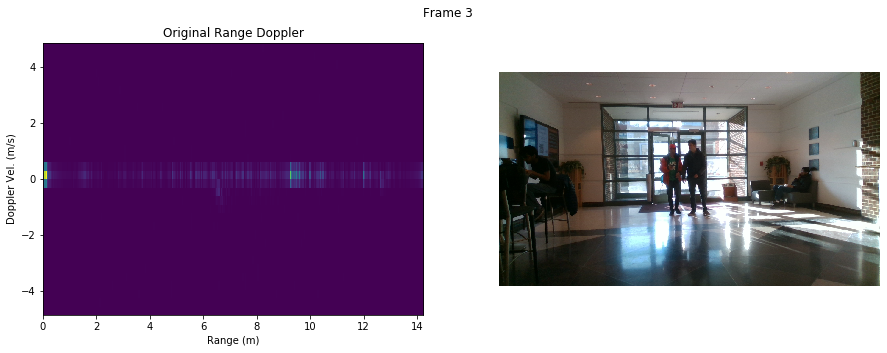

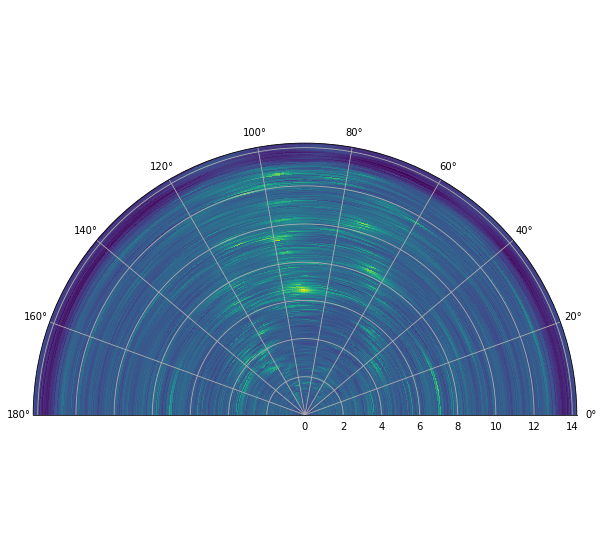

In [37]:
random_int = np.random.randint(0,len(radar_frames))
test_radar_frame = radar_frames[random_int]

test_radar_cube = mm.dsp.range_processing(test_radar_frame)
(test_log_doppler_cube, test_doppler_cube) = mm.dsp.doppler_processing(test_radar_cube,
                                             num_tx_antennas=iwr_cfg_dict['numTx'], clutter_removal_enabled=False,
                                             interleaved=False, window_type_2d=mm.dsp.utils.Window.HAMMING,
                                             accumulate=False,phase_correction=True)

test_doppler_cube = np.fft.fftshift(test_doppler_cube, axes=(2,))
test_log_doppler_cube = np.fft.fftshift(test_log_doppler_cube, axes=(2,))



plt.figure(figsize=(15,5))
plt.suptitle('Frame %d'%random_int)
plt.subplot(121)
plt.imshow(np.abs(test_doppler_cube[:,0]).T,aspect='auto',origin='lower', 
           extent=[0,304*range_res,-test_log_doppler_cube.shape[2] * dop_res / 2, test_log_doppler_cube.shape[2] * dop_res / 2])
plt.title('Original Range Doppler')
plt.xlabel('Range (m)')
plt.ylabel('Doppler Vel. (m/s)')
plt.subplot(122)
plt.imshow(images[random_int])
plt.axis('off')
plt.show()



BINS_PROCESSED = test_doppler_cube.shape[0]  # If you want to zoom in plot, make this 120
VIRT_ANT = test_doppler_cube.shape[1]  # virtual antennas because we use time division multiple access to simulate a larger antenna array
DOPPLER_BINS = test_doppler_cube.shape[2]
ANGLE_RES = 1  # 1 degree resolution
ANGLE_RANGE = 90 # so we get 181 angle bins [0,180]
ANGLE_BINS = (ANGLE_RANGE * 2) // ANGLE_RES + 1
range_azimuth = np.zeros((ANGLE_BINS, BINS_PROCESSED), dtype=np.complex_)
num_vec, steering_vec = mm.dsp.gen_steering_vec(ANGLE_RANGE, ANGLE_RES, VIRT_ANT) # steering vector is a(theta) in most literature

beamforming_result = np.zeros([BINS_PROCESSED,ANGLE_BINS],dtype=np.complex_) # range bins x angle bins


for jj in range(BINS_PROCESSED):
    beamforming_result[jj,:], _ = mm.dsp.aoa_capon(test_doppler_cube[jj], steering_vec)

plt.figure(figsize=(15,10))
plt.tight_layout(True)
plt.subplot(111, projection='polar')
azimuths = np.radians(np.linspace(0, 180, 181))
zeniths = np.linspace(0, range_res*BINS_PROCESSED, BINS_PROCESSED)
r, theta = np.meshgrid(zeniths, azimuths)
values = beamforming_result.T
plt.pcolormesh(theta, r, np.log(np.abs(values)))
plt.grid()
plt.xlim([0,np.pi])
plt.show()

## Clutter Suppression

#### Subtract Mean Over Chirps for each frame

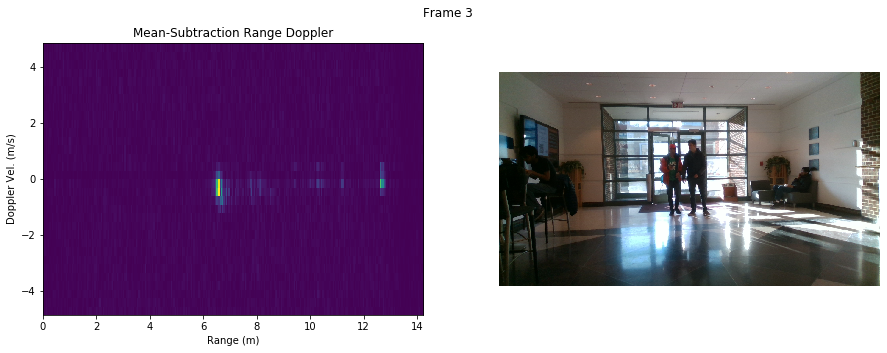

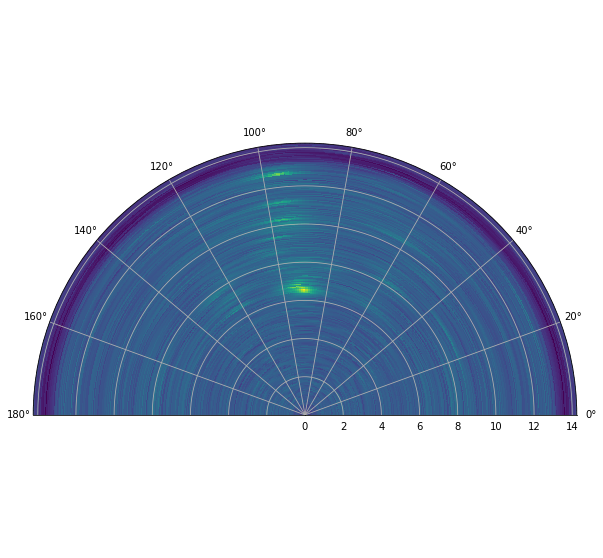

In [38]:
test_radar_frame = radar_frames[random_int]

test_radar_cube = mm.dsp.range_processing(test_radar_frame)
mean = test_radar_cube.mean(0)                 
test_radar_cube = test_radar_cube - mean


(test_log_doppler_cube, test_doppler_cube) = mm.dsp.doppler_processing(test_radar_cube,
                                             num_tx_antennas=iwr_cfg_dict['numTx'], clutter_removal_enabled=False,
                                             interleaved=False, window_type_2d=mm.dsp.utils.Window.HAMMING,
                                             accumulate=False,phase_correction=True)

test_doppler_cube = np.fft.fftshift(test_doppler_cube, axes=(2,))
test_log_doppler_cube = np.fft.fftshift(test_log_doppler_cube, axes=(2,))



plt.figure(figsize=(15,5))
plt.suptitle('Frame %d'%random_int)
plt.subplot(121)
plt.imshow(np.abs(test_doppler_cube[:,0]).T,aspect='auto',origin='lower', 
           extent=[0,304*range_res,-test_log_doppler_cube.shape[2] * dop_res / 2, test_log_doppler_cube.shape[2] * dop_res / 2])
plt.title('Mean-Subtraction Range Doppler')
plt.xlabel('Range (m)')
plt.ylabel('Doppler Vel. (m/s)')
plt.subplot(122)
plt.imshow(images[random_int])
plt.axis('off')
plt.show()

beamforming_result = np.zeros([BINS_PROCESSED,ANGLE_BINS],dtype=np.complex_) # range bins x angle bins


for jj in range(BINS_PROCESSED):
    beamforming_result[jj,:], _ = mm.dsp.aoa_capon(test_doppler_cube[jj], steering_vec)

plt.figure(figsize=(15,10))
plt.tight_layout(True)
plt.subplot(111, projection='polar')
# # cartesian coordinates (looks like real life)
# beamforming_result = np.flip(beamforming_result,axis=1)  # dont know why we need this but we'll be using own polar transform in future
#
azimuths = np.radians(np.linspace(0, 180, 181))
zeniths = np.linspace(0, range_res*BINS_PROCESSED, BINS_PROCESSED)
r, theta = np.meshgrid(zeniths, azimuths)
values = beamforming_result.T
plt.pcolormesh(theta, r, np.log(np.abs(values)))
plt.grid()
plt.xlim([0,np.pi])
plt.show()

#### Zeroing Out Highest Signular Value

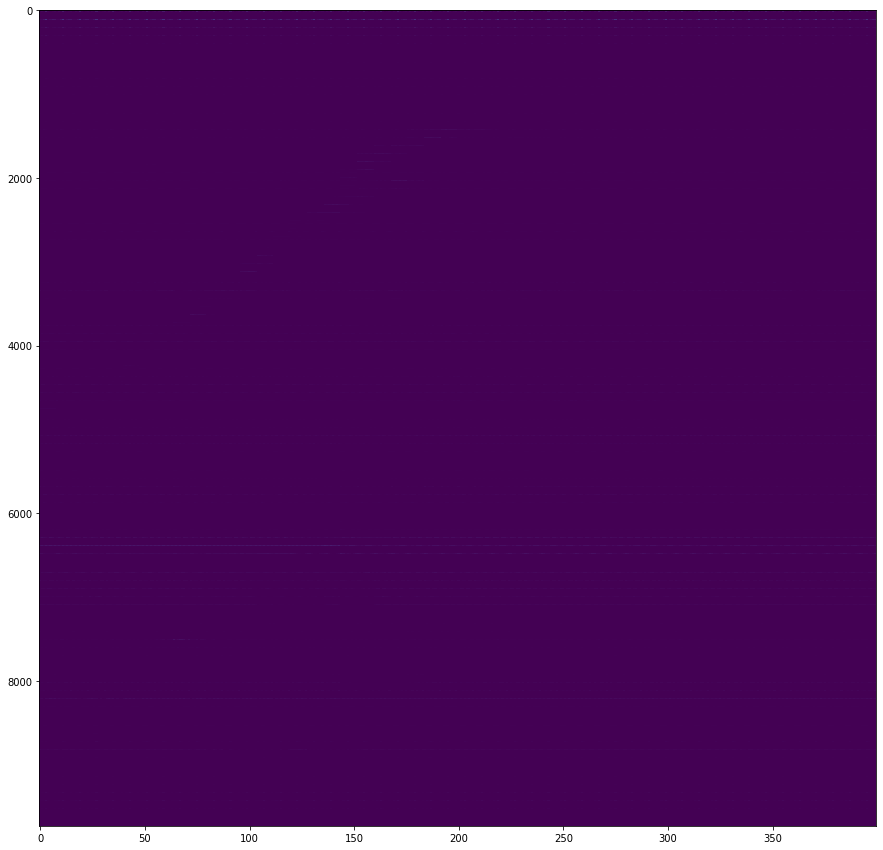

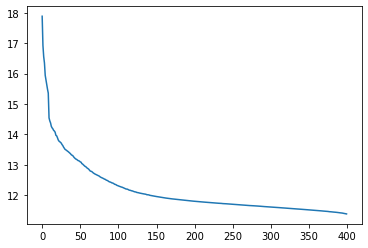

In [39]:
combined_shape = np.array([BINS_PROCESSED*DOPPLER_BINS,len(radar_frames)*VIRT_ANT],dtype=np.int)
combined_mat = np.zeros(combined_shape,dtype=np.complex)

for ii in range(len(radar_frames)):

    test_radar_frame = radar_frames[ii]

    test_radar_cube = mm.dsp.range_processing(test_radar_frame)
    (_, test_doppler_cube) = mm.dsp.doppler_processing(test_radar_cube,
                                                 num_tx_antennas=iwr_cfg_dict['numTx'], clutter_removal_enabled=False,
                                                 interleaved=False, window_type_2d=mm.dsp.utils.Window.HAMMING,
                                                 accumulate=False,phase_correction=True)

    test_doppler_cube = np.fft.fftshift(test_doppler_cube, axes=(2,))
    test_doppler_cube = np.swapaxes(test_doppler_cube,0,1).reshape(VIRT_ANT,-1)
    combined_mat[:,ii*VIRT_ANT:(ii+1)*VIRT_ANT] = test_doppler_cube .T

plt.figure(figsize=(15,15))
plt.imshow(np.abs(combined_mat),aspect='auto')  
plt.show()

radar_frames_array = np.array(radar_frames)
radar_frames_array = np.swapaxes(radar_frames_array,1,2)

radar_frames_array = radar_frames_array.reshape(combined_shape) 
recon = np.zeros(combined_shape,dtype=np.complex)

n = len(radar_frames)*VIRT_ANT
u, s, vh = np.linalg.svd(combined_mat, full_matrices=True)
plt.plot(np.log(s))
plt.show()

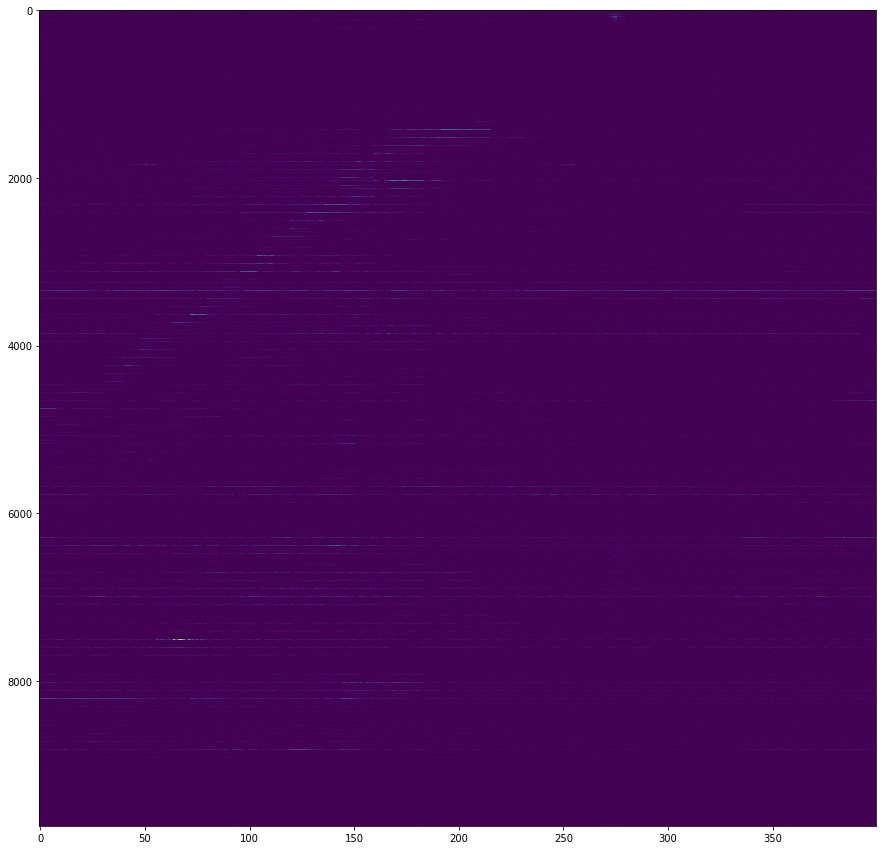

In [40]:
k = 20
s_edit = copy.copy(s)
s_edit[:k] = 0

smat = np.zeros((len(u), n))
smat[:n, :n] = np.diag(s_edit)
# np.allclose(composite, np.dot(u, np.dot(smat, vh)))

recon = np.dot(u, np.dot(smat, vh))
plt.figure(figsize=(15,15))
plt.imshow(np.abs(recon),aspect='auto')  
plt.show()

In [41]:
recon = (recon.T).reshape((len(radar_frames),VIRT_ANT,BINS_PROCESSED,DOPPLER_BINS))

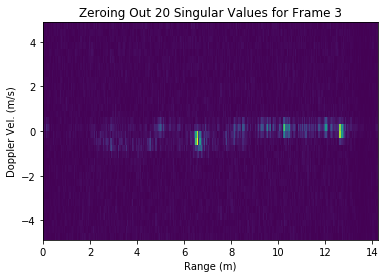

In [42]:
plt.imshow(np.abs(recon[random_int,0]).T,aspect='auto',origin='lower', 
           extent=[0,304*range_res,-test_log_doppler_cube.shape[2] * dop_res / 2, test_log_doppler_cube.shape[2] * dop_res / 2])
plt.title('Zeroing Out %d Singular Values for Frame %d'%(k,random_int))
plt.xlabel('Range (m)')
plt.ylabel('Doppler Vel. (m/s)')
plt.show()

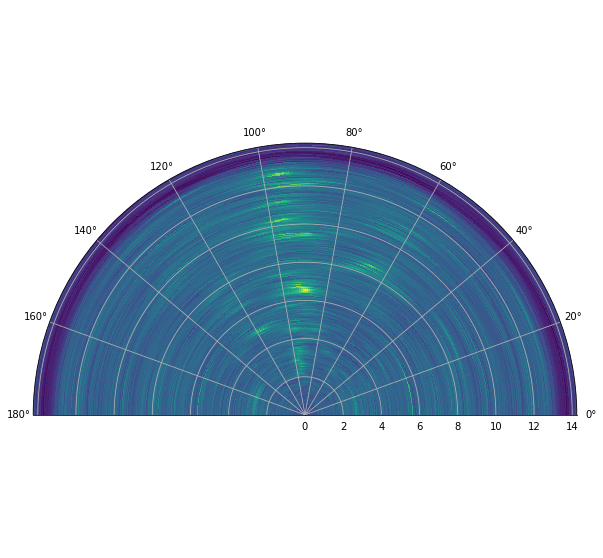

In [43]:
recon = np.swapaxes(recon,1,2)
beamforming_result = np.zeros([BINS_PROCESSED,ANGLE_BINS],dtype=np.complex_) # range bins x angle bins


for jj in range(BINS_PROCESSED):
    beamforming_result[jj,:], _ = mm.dsp.aoa_capon(recon[random_int,jj], steering_vec)

plt.figure(figsize=(15,10))
plt.tight_layout(True)
plt.subplot(111, projection='polar')
# # cartesian coordinates (looks like real life)
# beamforming_result = np.flip(beamforming_result,axis=1)  # dont know why we need this but we'll be using own polar transform in future
#
azimuths = np.radians(np.linspace(0, 180, 181))
zeniths = np.linspace(0, range_res*BINS_PROCESSED, BINS_PROCESSED)
r, theta = np.meshgrid(zeniths, azimuths)
values = beamforming_result.T
plt.pcolormesh(theta, r, np.log(np.abs(values)))
plt.grid()
plt.xlim([0,np.pi])
plt.show()

#### RPCA with Complex Numbers

#### TVRPCA with Complex Numbers

## Target Clustering

## Determining Bounds